In [103]:
import gzip
from tensorflow.keras.utils import to_categorical

In [104]:
# Useful additional packages
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
from math import pi

In [113]:
from qiskit import QuantumCircuit, ClassicalRegister, QuantumRegister, execute
from qiskit.tools.visualization import circuit_drawer
from qiskit.quantum_info import state_fidelity
from qiskit import  Aer, transpile
from qiskit.circuit.library import CHGate
from qiskit.quantum_info.operators import Operator
from qiskit.aqua.operators import PrimitiveOp
from qiskit.aqua.operators.primitive_ops import MatrixOp
import qiskit

In [114]:
# EMNIST decoder

decoder = "0123456789ABCDEFGHIJKLMNOPQRSTUVWXYZabcdefghijklmnopqrstuvwxyz"

In [115]:
images_raw = gzip.open("data/EMNIST/gzip/emnist-balanced-train-images-idx3-ubyte.gz", "r")
labels_raw = gzip.open("data/EMNIST/gzip/emnist-balanced-train-labels-idx1-ubyte.gz")


image_size = 28
num_images = 256 # how many images per batch

images_raw.read(16) # reads the data type
labels_raw.read(8) # reads the data type

def get_data(images, labels):
    buf_images = images.read(image_size * image_size * num_images)
    images = np.frombuffer(buf_images, dtype=np.uint8).astype(np.float32)
    images = images.reshape(num_images, image_size, image_size, 1)
    
    buf_labels = labels.read(num_images)
    labels = np.frombuffer(buf_labels, dtype=np.uint8).astype(np.int32)
    
    return images, labels

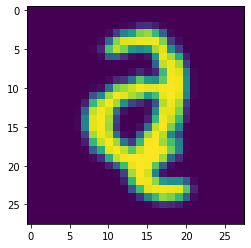

a


In [116]:
# print images
data = get_data(images_raw, labels_raw)

images = data[0]
labels = data[1]

image = np.asarray(images[1]).T.squeeze()
plt.imshow(image)
plt.show()

print(decoder[labels[1]])

In [117]:
def get_num_cls(data):
    labels = np.array(data[1])
    one_hot_labels = to_categorical(labels)
    
    return one_hot_labels.shape[1]


In [118]:
N = 10 # get_num_cls(data)
print(N)

10


In [209]:
class State_Prep:
    """see:
        https://arxiv.org/pdf/1908.08385.pdf
        equations 1 and 2
        also see:
        https://qiskit.org/documentation/stubs/qiskit.circuit.library.CHGate.html
    """
    def __init__(self, N, x):
        """"""
        self.N = 1
        self.target_N = N
        self.SU_of_N = np.asarray([[1]])
        # self.lie_algebra = 1
        self.x = x
        # self.mat = np.asarray([[0, -1j], [1j, 0]])
        self.alpha = np.arange(start=1, stop= self.target_N ** 2 + 1, dtype=np.complex_)
        self.K = 1
        self.P = self.K * np.exp(1j * np.asarray([[0, -1j], [1j, 0]])) * self.K


    
    def H(self):
        """"""
        h = []
        
        for i in range(self.target_N):
            h.append([0])

        #print(h)
        
        for i in range(self.target_N):
            for k in range(1, self.target_N):
                # print("k = ", k)
                circ1 = QuantumCircuit(2)
                circ1.h(0)
                circ1.cx(0, 1)
                ket_k = Operator(circ1)
                
                
                term0 = np.exp(((1j * 2 * np.pi * i * k - 1)  / self.target_N))
                try:
                    term1 = term1 + term0
                except:
                    term1 = term0 * ket_k

            h[i] = term1
        h = np.asarray(h)
        H_op = 1 / np.sqrt(self.target_N) * h

        return H_op
        
    def quNit(self):
        S3 = np.zeros(shape=(self.target_N, self.target_N))
        np.fill_diagonal(S3, val=-(self.target_N - 1) / 2)
        W = np.zeros(shape=self.x.shape) # learnable similar to weights
        sum_of_weights = np.sum(W @ self.x)
        print(sum_of_weights)
        Z = np.exp(1j * S3 * sum_of_weights)
        
        # Z_op = PrimitiveOp(Z)
        
        return Z * self.H() # need to use actual gate place holder
 ##################################################   
    
    def driver_for_SUG(self):
        """finds the value for alpha which is a self.target_N set"""
        
        
        print(self.SU_of_N.shape[0] * self.SU_of_N.shape[1])
        print(self.alpha.shape)
        
        return self.SU_of_N / self.alpha.reshape(self.target_N, self.target_N)
    
    
    def direct_sum(self, a, b):
        """"""
        if isinstance(a, int) and a == 1:
            a = np.asarray([a])[np.newaxis]

        # print("a = ", a)
        # print("b = ", b)
        # dsum = np.zeros( np.add(a.shape,b.shape), dtype=np.complex_ )
        # dsum[:a.shape[0],:a.shape[1]]=a
        # dsum[a.shape[0]:,a.shape[1]:]=b
        dsum = a + b
        # print(dsum)
        return dsum

    def A(self, k, lie_alge, a):
        term0 = 1j * lie_alge * 3 * a * (2 * k - 3)
        term1 = np.exp(term0)
        term2 = 1j * lie_alge
        term3 = np.exp(term2)
        term4 = ((k-1) ** 2 + 1) * a * (2 * (k - 1))
        term5 = term3 * term4
        term6 = term1 * term5
        
        return term6

    def lie_algebra(self):
        
        if self.N == 1:
            return 1
        if not isinstance(self.K, int):
            print(self.K.shape, "K lie")
            print(self.P.shape, "P lie")
        
        lie_alg = self.direct_sum(self.K,  self.P)
        
        # print("lie", lie_alg.shape)
        
        return lie_alg
    
    def mat(self):
        if self.N > 1:
            n = self.N
            mat = np.zeros(shape=(n, n), dtype=np.complex_)
            mat[0, n - 1] = -1j
            mat[n - 1, 0] = 1j
            
        else:
            mat = np.asarray([[1]], dtype=np.complex_)
        # print("mat", mat.shape)
        # print(mat)
        
        return mat
        
    
    def Euler_angle_param(self):
        """"""
        print("RUN", self.N - 1)
        if self.N == self.target_N + 1:
            print("SU of N FOR {} FOUND".format(self.N - 1))
            return self.SU_of_N  
        

        if self.N < 2:
            A = 1
        else:
            A = np.array([0])
            lie_alge = self.lie_algebra()
            for k in range(self.target_N):
                #print(k)
                for a in self.alpha:
                    #print(a)
                    try:
                        B = self.A(k, lie_alge, a)
                        A = np.vdot(A, B)
                    except:
                        A = self.A(k, lie_alge, a)
                    
                    
        self.N += 1
        lie_algebra = self.lie_algebra()
        self.P = self.K * np.exp(1j * self.mat()) * self.K

        self.SU_of_N = self.K * lie_algebra * A
        self.K = self.Euler_angle_param()
        return self.SU_of_N
        
        
        
        #return self.Euler_angle_param()
    

In [211]:
vector_x = State_Prep(N, image)
output = vector_x.quNit()
print(output)



0.0
[[0], [0], [0], [0], [0], [0], [0], [0], [0], [0]]
k =  1
k =  2
k =  3
k =  4
k =  5
k =  6
k =  7
k =  8
k =  9
k =  1
k =  2
k =  3
k =  4
k =  5
k =  6
k =  7
k =  8
k =  9
k =  1
k =  2
k =  3
k =  4
k =  5
k =  6
k =  7
k =  8
k =  9
k =  1
k =  2
k =  3
k =  4
k =  5
k =  6
k =  7
k =  8
k =  9
k =  1
k =  2
k =  3
k =  4
k =  5
k =  6
k =  7
k =  8
k =  9
k =  1
k =  2
k =  3
k =  4
k =  5
k =  6
k =  7
k =  8
k =  9
k =  1
k =  2
k =  3
k =  4
k =  5
k =  6
k =  7
k =  8
k =  9
k =  1
k =  2
k =  3
k =  4
k =  5
k =  6
k =  7
k =  8
k =  9
k =  1
k =  2
k =  3
k =  4
k =  5
k =  6
k =  7
k =  8
k =  9
k =  1
k =  2
k =  3
k =  4
k =  5
k =  6
k =  7
k =  8
k =  9
[[Operator([[ 0.2023278+0.j,  0.2023278+0.j,  0.       +0.j,  0.       +0.j],
            [ 0.       +0.j,  0.       +0.j,  0.2023278+0.j, -0.2023278+0.j],
            [ 0.       +0.j,  0.       +0.j,  0.2023278+0.j,  0.2023278+0.j],
            [ 0.2023278+0.j, -0.2023278+0.j,  0.       +0.j,  0.       +0.j]],
  

In [53]:
vector_x.Euler_angle_param()
SU_N = vector_x.driver_for_SUG()
print(SU_N)
SU_Nx = Operator(SU_N)
print(Operator.is_unitary(SU_Nx))

RUN 0
RUN 1
RUN 2
RUN 3
RUN 4
RUN 5
RUN 6
RUN 7
RUN 8
RUN 9
RUN 10
RUN 11
RUN 12
RUN 13
RUN 14
RUN 15
RUN 16
RUN 17
RUN 18
RUN 19
RUN 20
RUN 21
RUN 22
RUN 23
RUN 24
RUN 25
RUN 26
RUN 27
RUN 28
RUN 29
RUN 30
RUN 31
RUN 32
RUN 33
RUN 34
RUN 35
RUN 36
RUN 37
RUN 38
RUN 39
RUN 40
RUN 41
RUN 42
RUN 43
RUN 44
RUN 45
RUN 46
RUN 47
SU of N FOR 47 FOUND
2209
(2209,)
[[-7.56416461e+08+2.77110529e+08j -3.78208230e+08+1.38555265e+08j
  -2.52138820e+08+9.23701765e+07j ... -1.68092547e+07+6.15801177e+06j
  -1.64438361e+07+6.02414194e+06j  2.96938853e+07-1.15624261e+07j]
 [-1.57586763e+07+5.77313603e+06j -1.54370706e+07+5.65531693e+06j
  -1.51283292e+07+5.54221059e+06j ... -8.22191805e+06+3.01207097e+06j
  -8.13351033e+06+2.97968311e+06j -8.04698362e+06+2.94798436e+06j]
 [-7.96227853e+06+2.91695294e+06j -7.87933813e+06+2.88656802e+06j
  -7.79810784e+06+2.85680958e+06j ... -5.44184504e+06+1.99360093e+06j
  -5.40297472e+06+1.97936092e+06j -5.36465575e+06+1.96532290e+06j]
 ...
 [-3.65595196e+05+1.339345

In [55]:
op = np.vdot(SU_N, output)
print(op)
op = Operator(op)

print(Operator.is_unitary(op))

(-5665840242.735417-2077439317.8697426j)


QiskitError: 'Invalid input data format for Operator'